In [1]:
# !conda install -n sentiment ipykernel --update-deps --force-reinstall
# run above command if using python3.8

In [ ]:
import tensorflow as tf
import tensorflow_text as text  # Registers the ops.
import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow_addons.optimizers import AdamW
import matplotlib.pyplot as plt
import numpy as np
import os


print(os.getenv('LD_LIBRARY_PATH'))
print(tf.config.list_physical_devices('GPU'))

In [5]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Load dataset from TensorFlow Hub

In [40]:
(training_set, validation_set), dataset_info = tfds.load(
    'sentiment140',
    split=['train[:30%]', 'train[30%:32%]'],
    with_info=True,
    as_supervised=True,
)

In [41]:
num_training_examples = 0
for example in training_set:
  num_training_examples += 1

print(num_training_examples)

480000


In [42]:
val_training_examples = 0
for example in validation_set:
    val_training_examples += 1

print(val_training_examples)


32000


In [43]:
assert isinstance(training_set, tf.data.Dataset)
assert isinstance(validation_set, tf.data.Dataset)

In [67]:
# Convert tfds to a pandas dataframe to manipulate it

df_train_set = tfds.as_dataframe(training_set, dataset_info)
df_validation_set = tfds.as_dataframe(validation_set, dataset_info)

In [71]:
df_train_set.dropna()
df_train_set = df_train_set.replace(4,1) # represent positives as a 1 instead of a 4

df_validation_set.dropna()
df_validation_set = df_validation_set.replace(4,1)

# verify that there are no more 4s
np.where(df_train_set.to_numpy() == 4)
np.where(df_validation_set.to_numpy() == 4)

(array([], dtype=int64), array([], dtype=int64))

In [74]:
# just checkout out some elements
df_train_set.iat[3,0]
type(df_train_set.iat[1,0])

# get input and target outputs from dataframe to cast into tf dataset
target = df_train_set['polarity']
text = df_train_set['text']
dt = tf.data.Dataset.from_tensor_slices((text, target))
print(type(dt))
print(dt.take(1).as_numpy_iterator().next())
training_set = dt.prefetch(1)

# validation here
val_target = df_validation_set['polarity']
val_text = df_validation_set['text']
val_dt = tf.data.Dataset.from_tensor_slices((val_text, val_target))
validation_set = val_dt.prefetch(1)

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
(b"i'm 10x cooler than all of you! ", 1)


In [75]:
for text, labels in training_set.take(5):  # only take first element of dataset
    numpy_text = text.numpy()
    numpy_labels = labels.numpy()
    print(numpy_labels, numpy_text)

1 b"i'm 10x cooler than all of you! "
0 b'O.kk? Thats weird I cant stop following people on twitter... I have tons of people to unfollow '
1 b'what a beautiful day not to got to my first class '
1 b".@HildyGottlieb &amp; I was just saying to Maha'al yesterday, everything we ever needed to know was in Beatles' lyrics - you prove my point! "
0 b'kinda sad and confused  why do guys do this?'


### Training and validation sets after manipulation

In [76]:
BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).batch(BATCH_SIZE).prefetch(1)
train_val = validation_set.batch(BATCH_SIZE).prefetch(1)

## Load preprocesor for the albert model and the model itself

In [9]:
# TODO: Create a Feature Extractor
# First do some preprocessing on the input raw data to tokenize and create embeddings with the sequences

URL_PREPROCESSOR = "http://tfhub.dev/tensorflow/albert_en_preprocess/3"
preprocessor = hub.KerasLayer(URL_PREPROCESSOR, name='preprocessing')

In [10]:
text_test = ['this is such an amazing movie!']
text_preprocessed = preprocessor(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [   2   48   25  145   40 5289 1308  187    3    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [11]:
# let's look at the outputs from albert model

URL = "https://tfhub.dev/tensorflow/albert_en_base/3"
albert_model = hub.KerasLayer(URL, trainable=False)
albert_results = albert_model(text_preprocessed)
print(f'Pooled Outputs Shape:{albert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{albert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{albert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{albert_results["sequence_output"][0, :12]}')

Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.56420034 -0.583381    0.8920307  -0.88340575 -0.5900779  -0.9748928
  0.59733653 -0.56507444  0.6582606  -0.99990517  0.92246985  0.5789059 ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.93791425  0.2850878  -0.3770112  ...  0.1940784  -1.122175
   0.502108  ]
 [ 1.6732271  -1.2593404   0.98551434 ... -0.03488392  2.4402459
  -1.415178  ]
 [ 1.5726161  -0.72766566 -0.6132505  ...  1.136941   -0.24407187
  -0.20239015]
 ...
 [ 0.4637535   0.78065205 -0.00772761 ...  0.36924595  0.9916418
  -1.1032659 ]
 [ 0.44642836  0.8588993   0.02044564 ...  0.40769723  1.0863211
  -1.0217946 ]
 [ 0.46782282  0.8818836   0.02625225 ...  0.44045782  1.1098733
  -1.016713  ]]


In [12]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = preprocessor(text_input)
    encoder = hub.KerasLayer(URL, trainable=False, name='ALBERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    dropout_layer = tf.keras.layers.Dropout(0.1, name='dropout')
    # net = dropout_layer(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(inputs=text_input, outputs=net, name='albert_model')

build_classifier_model().summary()
# pooled_output = outputs["pooled_output"]      # [batch_size, 768].
# sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].
# print(pooled_output)
# print(sequence_output)

Model: "albert_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                           

In [81]:
model = build_classifier_model()
albert_raw_result = model(tf.constant(text_test))
print(tf.sigmoid(albert_raw_result))

tf.Tensor([[0.80214405]], shape=(1, 1), dtype=float32)


In [82]:
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
    [10000, 15000], [1e-1, 1e-2, 1e-3])
# lr and wd can be a function or a tensor
lr = 1e-3 * schedule(step)
wd = lambda: 1e-4 * schedule(step)

optimizer = AdamW(learning_rate=lr, weight_decay=wd)

In [83]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Training

In [84]:
epochs=6
init_lr = 5e-2
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: init_lr * 10**(epoch / 2))
# optimizer = tf.keras.optimizers.Adam(lr=init_lr)
metrics = tf.metrics.BinaryAccuracy()

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "sentiment_model_v1.h5", save_best_only=True, save_weights_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)


model.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = metrics)


history = model.fit(train_batches, validation_data=train_val, epochs=epochs, 
        callbacks=[model_checkpoint, early_stopping])

# model.save("sentiment_model_v1.h5")


Epoch 1/6
15000/15000 [==============================] - 3529s 235ms/step - loss: 0.6275 - binary_accuracy: 0.5943 - val_loss: 0.6081 - val_binary_accuracy: 0.6009
Epoch 2/6
15000/15000 [==============================] - 3461s 231ms/step - loss: 0.5972 - binary_accuracy: 0.6375 - val_loss: 0.5908 - val_binary_accuracy: 0.6333
Epoch 3/6
15000/15000 [==============================] - 3326s 222ms/step - loss: 0.5873 - binary_accuracy: 0.6502 - val_loss: 0.5833 - val_binary_accuracy: 0.6586
Epoch 4/6
15000/15000 [==============================] - 3321s 221ms/step - loss: 0.5822 - binary_accuracy: 0.6566 - val_loss: 0.5795 - val_binary_accuracy: 0.6672
Epoch 5/6
15000/15000 [==============================] - 3246s 216ms/step - loss: 0.5788 - binary_accuracy: 0.6605 - val_loss: 0.5794 - val_binary_accuracy: 0.6817
Epoch 6/6
15000/15000 [==============================] - 3319s 221ms/step - loss: 0.5767 - binary_accuracy: 0.6632 - val_loss: 0.5752 - val_binary_accuracy: 0.6720


In [89]:
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


# Plot Training and Validation Graphs

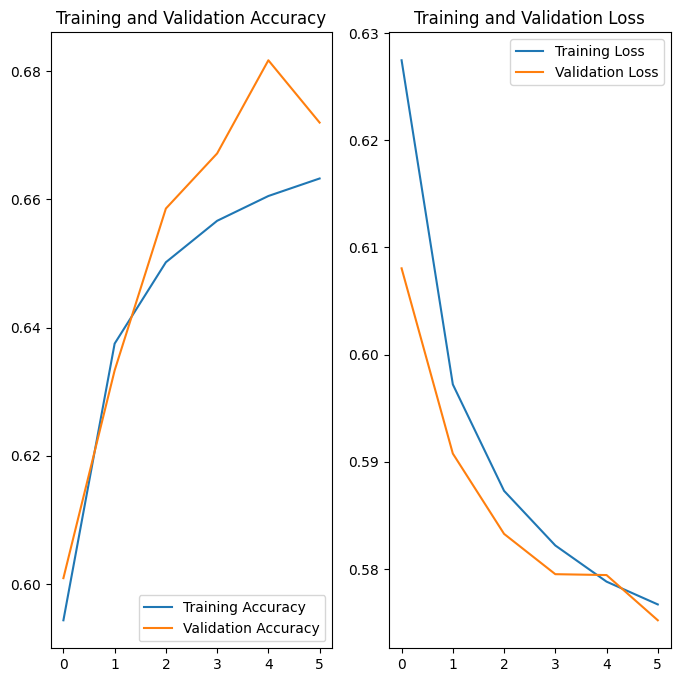

In [90]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()